In [1]:
from pathlib import Path
from tempfile import NamedTemporaryFile
import os

import numba
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mol2vec import features
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from gensim.models import word2vec

Traceback (most recent call last):
  File "/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py", line 130, in <module>
    if 'display.width' in pd.core.config._registered_options:
AttributeError: module 'pandas.core' has no attribute 'config'


In [2]:
model = word2vec.Word2Vec.load("../../models/mol2vec_model.pkl")

In [3]:
# This gives the size of our corpus: basically how many different environments
# our model is aware of
print(len(model.wv.vocab))

36399


In [4]:
# Generate some small molecules for comparison and sanity check!
benzene = Chem.MolFromSmiles("c1ccccc1")
acetaldehyde = Chem.MolFromSmiles("CC=O")
benzonitrile = Chem.MolFromSmiles("C1=CC=C(C=C1)C#N")
phenol = Chem.MolFromSmiles("Oc1ccccc1")
hc5n = Chem.MolFromSmiles("C#CC#CC#N")

molecules = [benzene, acetaldehyde, benzonitrile, phenol, hc5n]

We now convert the `Mol` objects into "sentences" to be processed by our `mol2vec` model.

In [5]:
# Translate molecules
sentences = [features.mol2alt_sentence(mol, 1) for mol in molecules]

# Use our trained model to generate vectors for every sentence
vectors = features.sentences2vec(sentences, model)

So now every molecule is converted into a 300 dimensional vector! To check how similar molecules are, we can compute the cosine similarity, which is given by this formula:

$$ \cos(\theta) = \frac{\bf{A} \dot \bf{B}}{\vert\vert \bf{A} \vert\vert \vert\vert \bf{B} \vert\vert} $$

This metric basically measures the angle subtended between two vectors $\bf{A}, \bf{B}$. For orthogonal vectors (i.e. completely dissimilar), $\cos(\theta)=0$ and two equivalent vectors $\cos(\theta)=1$ (two equivalent molecules). The code below implements this measure, as well as a fast(er) implementation for calculating every pair.

In [17]:
@numba.jit(fastmath=True)
def cosine_similarity(A, B):
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))


@numba.jit(fastmath=True)
def pairwise_similarity(vectors):
    n = len(vectors)
    matrix = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(n):
            matrix[i,j] = cosine_similarity(vectors[i], vectors[j])
    return matrix

In [7]:
pairwise_similarity(vectors)

array([[1.        , 0.48067454, 0.89181936, 0.95223397, 0.22049767],
       [0.48067454, 1.        , 0.5183025 , 0.5278091 , 0.2662749 ],
       [0.89181936, 0.5183025 , 1.0000001 , 0.87767535, 0.5311317 ],
       [0.95223397, 0.5278091 , 0.87767535, 1.        , 0.22908221],
       [0.22049767, 0.2662749 , 0.5311317 , 0.22908221, 0.9999999 ]],
      dtype=float32)

This matrix shows the cosine similarity between every molecule pair: the diagonal entries are all 1, because they're the same molecule (good sanity check), while the off-diagonal elements compare each molecule.

In row order, we have: benzene, acetaldehyde, benzonitrile, phenol, HC5N. From chemical intuition, benzene, benzonitrile, and phenol should be very similar with one another because they all contain a benzene ring. Acetaldehyde should be closest to phenol because of oxygen. HC5N should be similar to benzonitrile because of the nitrile group.

The first and third statements hold well, and they meet our expectations! The second one is a bit more dicey, as the result suggests that acetaldehyde is closer to benzonitrile than phenol despite what we originally thought. In this case, it's very likely that our `mol2vec` model isn't entirely doing what we're thinking, and we would need to do more tests to understand why this is. The encoding must not be focusing on the oxygen as much: for these comparisons, we would have to either: (a) tune the `mol2vec` model, (b) use a different type of encoding, or (c) use a different measure of similarlity.

## Comparison with TMC-1 molecules

In this section we take a look at seeing if the `mol2vec` model is behaving as we think it should using molecules known in TMC-1. We'll take methyl cyanide (CH$_3$CN) and use it as a basis for comparison with a few select species to highlight it.

In [8]:
# retired in favor of the module version below

# def smi_to_vector(smi: str, model):
#     mol = Chem.MolFromSmiles(smi, sanitize=False)
#     mol.UpdatePropertyCache(strict=False)
#     Chem.GetSymmSSSR(mol)
#     # generate a sentence from rdkit molecule
#     sentence = features.mol2alt_sentence(mol, radius=1)
#     # generate vector embedding from sentence and model
#     vector = features.sentences2vec([sentence], model)
#     return vector

Read in the TMC-1 molecules list, and for now well ignore isotopologues.

In [5]:
df = pd.read_csv("../../data/raw/TMC-1_inventory.csv")

In [6]:
df = df.loc[df["Isotopologue"] != 1]

In [7]:
from umda.smi_vec import canonicize_smi, smi_to_vector

In [8]:
tmc1_canonical = [canonicize_smi(smi) for smi in df["SMILES"].tolist()]

In [10]:
# Generate vectors for all of the molecules in TMC
tmc_1_vecs = [smi_to_vector(smi, model)[0] for smi in tmc1_canonical]

In [11]:
df["Vecs"] = tmc_1_vecs

In [22]:
df["SMILES"] = tmc1_canonical

In [12]:
# Check out what the dataframe looks like
df.head()

,Molecule,Formula,SMILES,Column density (cm^-2),DOI,Isotopologue,Upper Limit,Notes,Vecs
0,Methyltriacetylene,CH3C6H,CC#CC#CC#C,3.100000e+12,10.1086/504918,0,0,Remijan,"[2.0953827, -4.50535, 0.52709067, -1.2093838, ..."
1,Methyldiacetylene,CH3C4H,CC#CC#C,3.000000e+13,NaN,0,0,"Walmsley et al 1984, MacLoed et al 1984, Loren...","[2.0440433, -2.4653375, 0.2275491, -0.7743592,..."
2,Methylcyanodiacetylene,CH3C5N,CC#CC#CC#N,8.400000e+11,10.1086/504918,0,0,Remijan,"[1.207319, -5.1080704, -0.039868705, -1.834622..."
3,Methylcyanoacetylene,CH3C3N,CC#CC#N,1.800000e+12,10.1086/504918,0,0,Remijan,"[1.1559796, -3.068057, -0.3394103, -1.3995979,..."
5,Protonated nitrogen,N2H+,N#[NH+],5.000000e+12,10.3847/1538-4365/aa69ba,0,0,"FCRAO, 1 - 0; towards CP","[0.11407158, -0.76171607, -0.95510256, -0.7127..."


Now we want a dictionary so that we can map the name of the molecule (which is more convenient) to its vector.

In [13]:
molecule_dict = {mol: vector for mol, vector in zip(df["Molecule"], df["Vecs"])}

In [14]:
selected = ["Methyl cyanide", "Methylcyanodiacetylene", "Acetaldehyde", "2-Propynal", "Vinylcyanide", "Carbonyl sulfide"]

In [18]:
# compute cosine similarity with methyl cyanide
similarities = [cosine_similarity(molecule_dict["Methyl cyanide"], molecule_dict[chosen]) for chosen in selected]

In [19]:
# similarity of methyl cyanide with itself should be basically one for sanity check
similarities

[0.9999998807907104,
 0.8952176570892334,
 0.4643494486808777,
 0.6710745692253113,
 0.7188612222671509,
 0.45724305510520935]

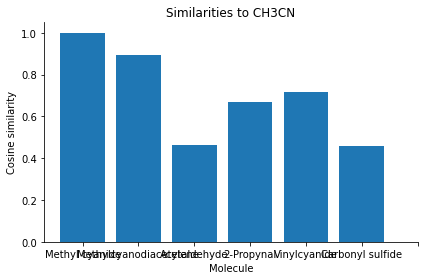

In [20]:
fig, ax = plt.subplots()

ax.bar(x=np.arange(len(similarities)), height=similarities)

ax.set(xlabel="Molecule", ylabel="Cosine similarity", xticklabels=selected, xticks=range(7), title="Similarities to CH3CN")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

fig.tight_layout()
# fig.savefig("ch3cn_similarity.png", dpi=300)

In [24]:
df.to_pickle("../../data/interim/tmc1_table_vecs.pkl")